In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
import math
import os

In [2]:
df = pd.read_parquet(r"data/pp_joind.parquet", engine="pyarrow")

In [3]:
na_counts = df.isna().sum()
na_counts_df = na_counts.reset_index()
na_counts_df.columns = ['Coluna', 'Qtd_NaNs']
print(na_counts_df)

df = df.dropna(axis=0)

                                      Coluna  Qtd_NaNs
0                                       Data         0
1                                      Grupo         0
2                                  Detentora         0
3                                     Vendor         0
4                                     eNodeB         0
5                                       Cell         0
6                       TIM_PRB_AVAIL (Unid)        72
7                   TIM_PRB_UTIL_MEAN_DL (%)       186
8            TIM_PRB_UTIL_MEAN_DL_DEN (Unid)        72
9            TIM_PRB_UTIL_MEAN_DL_NUM (Unid)        72
10             TIM_THROU_USER_PDCP_DL (Kbps)       636
11           TIM_THROU_USER_PDCP_DL_DEN (ms)        72
12          TIM_THROU_USER_PDCP_DL_NUM (bit)        72
13  TIM_USERS_RRC_CONN_MEAN_SUM_ALLOP (Unid)        72
14          TIM_VOLUME_DADOS_DLUL_ALLOP (KB)        72
15            TIM_VOLUME_DADOS_DL_ALLOP (KB)        72
16                              SET_NUMBER_0         0
17        

In [4]:
# Definir número de clusters
n_clusters = 3

# Selecionar apenas colunas numéricas
num_cols = df.select_dtypes(include="number").columns
X_scaled = StandardScaler().fit_transform(df[num_cols])

# Transpor (skfuzzy espera features nas linhas e amostras nas colunas)
X_scaled_T = X_scaled.T

# Rodar fuzzy c-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled_T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Atribuir cluster mais provável
labels = u.argmax(axis=0)
df["cluster_fuzzy"] = labels

# Adicionar pertinências de cada cluster
for idx in range(n_clusters):
    df[f"pertinencia_cluster_{idx}"] = u[idx]

# Salvar resultado em apenas UM arquivo
nome_arquivo = os.path.join("data", "particao_1.csv")
df.to_csv(nome_arquivo, index=False)
print(f"Arquivo salvo em {nome_arquivo} com {len(df)} linhas")

Arquivo salvo em data\particao_1.csv com 20172 linhas


In [5]:
# Caminho da partição única
caminho = "data/particao_1.csv"

# Criar pasta results se não existir
os.makedirs("results", exist_ok=True)

# Ler o CSV
df = pd.read_csv(caminho, engine="pyarrow")

# Verificar se as colunas necessárias existem
required_cols = ['TIM_THROU_USER_PDCP_DL (Kbps)', 'TIM_PRB_UTIL_MEAN_DL (%)', 'cluster_fuzzy']
if not all(col in df.columns for col in required_cols):
    print(f"ERROR: {caminho} não possui as colunas necessárias {required_cols}.")
else:
    # Calcular número de clusters encontrados
    n_clusters = df['cluster_fuzzy'].nunique()

    # Criar gráfico
    plt.figure(figsize=(8, 6))
    plt.scatter(
        df['TIM_THROU_USER_PDCP_DL (Kbps)'],
        df['TIM_PRB_UTIL_MEAN_DL (%)'],
        c=df['cluster_fuzzy'],
        cmap='viridis',
        s=10
    )
    plt.title(f'Fuzzy C Means Throughput vs PRB util - {os.path.basename(caminho)} - Clusters: {n_clusters}')
    plt.xlabel('Throughput DL (Kbps)')
    plt.ylabel('PRB Util Mean DL (%)')

    # Salvar gráfico em results
    nome_saida = os.path.join("results", "particao_1_fuzzy.png")
    plt.savefig(nome_saida, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"Gráfico salvo em {nome_saida}")


Gráfico salvo em results\particao_1_fuzzy.png


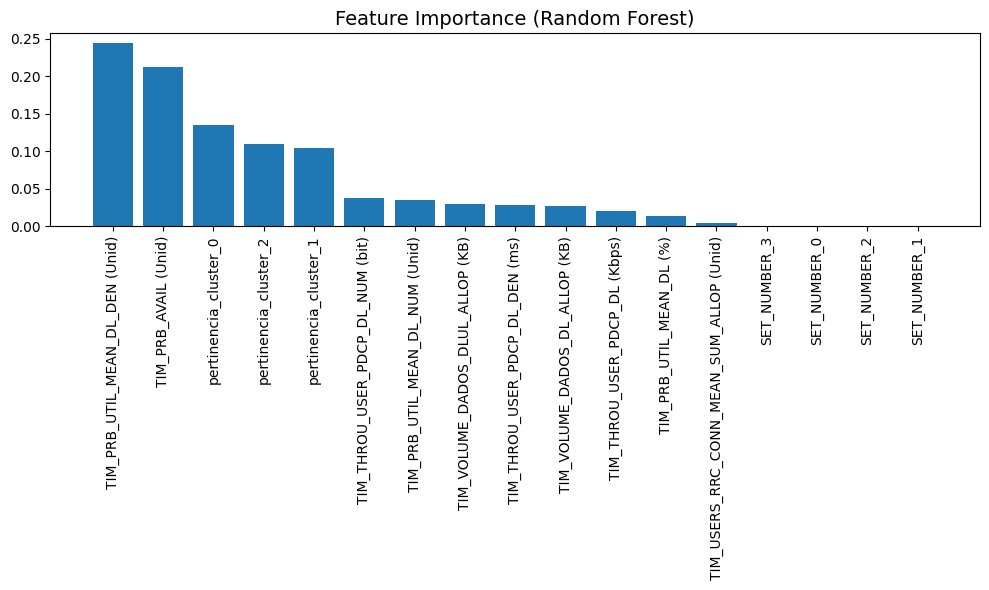

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Separar features numéricas e target
num_cols = df.select_dtypes(include="number").columns.drop("cluster_fuzzy")
X = df[num_cols]
y = df["cluster_fuzzy"]

# Treinar Random Forest para extrair importâncias
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

# Importâncias das features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plotar gráfico
plt.figure(figsize=(10, 6))
plt.bar(range(len(num_cols)), importances[indices], align="center")
plt.xticks(range(len(num_cols)), num_cols[indices], rotation=90)
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.tight_layout()
plt.show()

